This notebook was used to initially create cleanup and do some data exploration. It has not been updated with comments. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas_profiling

In [3]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [5]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [6]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [7]:
df=pd.read_csv('master.csv')

In [8]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [9]:
#country-year can be deleted, it doesn't contain any new information
#gdp_for_year should be a number not a string, and I don't want to type out that name
df.describe(exclude='number').T.sort_values('unique')

,count,unique,top,freq
sex,27820,2,male,13910
age,27820,6,75+ years,4642
generation,27820,6,Generation X,6408
country,27820,101,Austria,382
country-year,27820,2321,France2010,12
gdp_for_year ($),27820,2321,"650,532,654,582",12


In [10]:
#wrap up the cleaning into a simple function to run on the data 
def cleanUp(df):
    df['annual_gdp']=df[' gdp_for_year ($) '].str.replace(',','')
    
    df=df.drop([' gdp_for_year ($) ','country-year', 'suicides/100k pop', 'year'], axis=1)
    df['annual_gdp']=df['annual_gdp'].astype(int)
    
    countrySer=df.groupby('country')["HDI for year"].mean()
    def HDIcleanup(data):
        country=data[0]
        HDI=data[1]
        if np.isnan(HDI):       
            return countrySer[country]
        else:
            return HDI
    df['HDI_for_year']=df[['country','HDI for year']].apply(HDIcleanup,axis=1)
    df=df.drop('HDI for year', axis=1)
    df=df.dropna()
    y=df['suicides_no']
    df=df.drop('suicides_no',axis=1)
    return df, y

In [11]:
df, y=cleanUp(df)

In [12]:
X_train, X_test, y_train, y_test= train_test_split(df,y)

In [13]:
df.describe(exclude='number')

,country,sex,age,generation
count,26334,26334,26334,26334
unique,90,2,6,6
top,Austria,male,75+ years,Generation X
freq,382,13167,4394,6062


In [14]:
#suicides/100k is a calculation based on suicides_no (which is the target)
#this is a regression problem
df.describe()

,population,gdp_per_capita ($),annual_gdp,HDI_for_year
count,2.633400e+04,26334.000000,2.633400e+04,26334.000000
mean,1.753087e+06,17017.479836,4.494139e+11,0.774271
std,3.804919e+06,19215.718811,1.488713e+12,0.087415
min,4.240000e+02,251.000000,1.456417e+08,0.483000
25%,9.930000e+04,3424.000000,9.024567e+09,0.707900
50%,4.325410e+05,9070.000000,4.641892e+10,0.779600
75%,1.414290e+06,25165.000000,2.506385e+11,0.853000
max,4.380521e+07,126352.000000,1.812071e+13,0.944000


In [15]:
#HDI for year needs to be addressed. I think I want to impute the missing values by taking the mean 
#of the country, and then dropping the countries that don't have an HDI. 
#thats going to require writing a function to take in all the information
df[df['HDI_for_year'].isna()].groupby('country')['annual_gdp'].mean()

Series([], Name: annual_gdp, dtype: int64)

In [16]:
df.head()

,country,sex,age,population,gdp_per_capita ($),generation,annual_gdp,HDI_for_year
0,Albania,male,15-24 years,312900,796,Generation X,2156624900,0.673
1,Albania,male,35-54 years,308000,796,Silent,2156624900,0.673
2,Albania,female,15-24 years,289700,796,Generation X,2156624900,0.673
3,Albania,male,75+ years,21800,796,G.I. Generation,2156624900,0.673
4,Albania,male,25-34 years,274300,796,Boomers,2156624900,0.673


In [17]:
#begin with mean baseline
y_train.mean()
y_pred=np.full_like(y_train, y_train.mean())
mean_absolute_error(y_train, y_pred)


269.0913924050633

In [18]:
pipe=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    MinMaxScaler(),
    #SelectKBest(k=58),
    RandomForestRegressor(n_jobs=-1, n_estimators=100)
)

In [19]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['country', 'sex', 'age', 'generation'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('minmaxscal...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                 

In [20]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((19750, 8), (19750,), (6584, 8), (6584,))

In [21]:
#even using just those two metrics we are able to beat the mean baseline score
-cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

20.8840835443038

In [22]:
importance=pipe.named_steps['randomforestregressor'].feature_importances_

In [24]:
cols=pipe.named_steps['onehotencoder'].transform(X_train).columns
#cols=cols[pipe.named_steps['selectkbest'].get_support()].tolist()


In [25]:
X_train.head()
#pipe.named_steps['onehotencoder'].transform(X_train)

,country,sex,age,population,gdp_per_capita ($),generation,annual_gdp,HDI_for_year
12856,Italy,female,25-34 years,4391200,21472,Boomers,1177326294441,0.766000
15467,Luxembourg,male,15-24 years,24415,50788,Generation X,20209122027,0.851100
25744,Turkmenistan,male,35-54 years,258100,1003,Silent,3006988217,0.676800
4791,Bulgaria,female,35-54 years,1085400,4003,Boomers,29636617750,0.749000
19014,Philippines,female,25-34 years,6698777,1915,Generation X,149359918060,0.643333


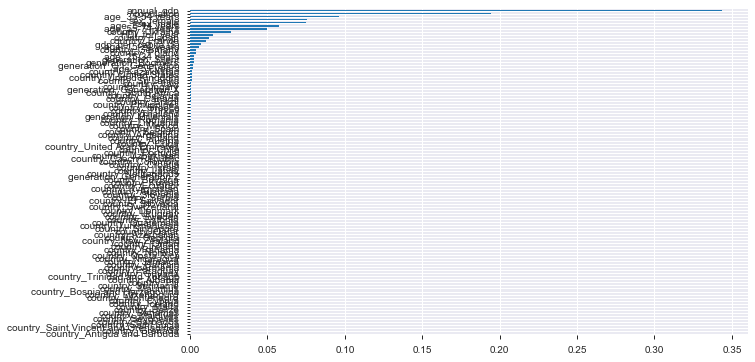

In [26]:
fig=plt.figure(figsize=(10,6))
pd.Series(index=cols, data=importance).sort_values().plot.barh()


In [28]:
import eli5
from eli5.sklearn import PermutationImportance

In [29]:
encoderpipe=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_encoded=encoderpipe.fit_transform(X_train)
model=RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train_encoded, y_train)

permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=2
)

permuter.fit(X_train_encoded,y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [30]:
features=X_train.columns.tolist()

In [31]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=features
)

Weight,Feature
278.0799 ± 1.3255,population
105.0877 ± 0.2043,sex
97.4022 ± 1.5155,annual_gdp
84.1382 ± 0.3320,age
49.5570 ± 0.0802,country
41.3154 ± 0.1488,HDI_for_year
16.8151 ± 0.0088,gdp_per_capita ($)
14.2008 ± 0.2765,generation


In [32]:
cross_val_score(model, X_train_encoded, y_train, scoring='neg_mean_absolute_error')

array([-31.05071385, -25.98089321, -28.47456631])

In [33]:
min_weight=30
mask=permuter.feature_importances_ > min_weight
features=X_train.columns[mask]
X_train_subset=X_train[features]
X_train_subset, X_val, y_train,y_val=train_test_split(X_train_subset, y_train)

In [34]:
encoder=ce.OrdinalEncoder()
X_train_enc=encoder.fit_transform(X_train_subset)
X_val_enc=encoder.transform(X_val)
model.fit(X_train_enc,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [35]:
-cross_val_score(model,X_train_enc, y_train, scoring='neg_mean_absolute_error').mean()

29.93894612744313

In [36]:
X_train_enc.columns

Index(['country', 'sex', 'age', 'population', 'annual_gdp', 'HDI_for_year'], dtype='object')

In [38]:
from xgboost import XGBRegressor

In [39]:
model=XGBRegressor(n_estimators=10000, learning_rate=.5, n_jobs=-1)


In [40]:
evals=[(X_train_enc, y_train),(X_val_enc, y_val)]
model.fit(X_train_enc, y_train, eval_set=evals, early_stopping_rounds=50,eval_metric='mae')

[0]	validation_0-mae:144.917	validation_1-mae:149.239
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:120.5	validation_1-mae:122.426
[2]	validation_0-mae:114.636	validation_1-mae:115.125
[3]	validation_0-mae:105.835	validation_1-mae:106.932
[4]	validation_0-mae:102.882	validation_1-mae:103.518
[5]	validation_0-mae:93.6018	validation_1-mae:95.3877
[6]	validation_0-mae:92.4629	validation_1-mae:93.775
[7]	validation_0-mae:90.6524	validation_1-mae:92.4145
[8]	validation_0-mae:86.6874	validation_1-mae:89.2246
[9]	validation_0-mae:85.6827	validation_1-mae:89.0208
[10]	validation_0-mae:85.0197	validation_1-mae:88.5581
[11]	validation_0-mae:82.7576	validation_1-mae:86.6698
[12]	validation_0-mae:81.7768	validation_1-mae:85.4671
[13]	validation_0-mae:80.2127	validation_1-mae:84.4558
[14]	validation_0-mae:79.8122	validation_1-mae:84.2108
[15]	validation_0-mae:79.257	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

This is odd. The XGBoost is not getting numbers that are any better than the tree. In fact they are worse. The best that the tree got was an MAE of about 20. 

In [41]:
import shap

In [46]:
row=X_train.iloc[[12856]]

In [48]:
explainer=shap.TreeExplainer(model)
row_processed = encoder.transform(row)
shap_values= explainer.shap_values(row_processed)

ValueError: Unexpected input dimension 8, expected 6

In [ ]:
feature='population'

isolated=pdp_isolate(
    model=pipe,
    dataset=X_train_subset,
    model_features=X_train_subset.columns.tolist(),
    feature=feature,
    num_grid_points=100
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=30)
plt.ylabel('number of suicides')
plt.ylim(0,3000)

In [ ]:
features=['population', 'HDI_for_year']
interaction=pdp_interact(
    model=pipe,
    dataset=X_train,
    model_features=X_train.columns.tolist(),
    features=features,
)
pdp_interact_plot(interaction, plot_type='grid',feature_names=features)

In [ ]:
X_train.isna().sum()

In [ ]:
pipe=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(),
    RandomForestRegressor(n_jobs=-1, n_estimators=100)
)

In [ ]:
search=GridSearchCV(pipe, {'selectkbest__k':range(1,len(cols))},n_jobs=-1,cv=3,verbose=20)

In [ ]:
search.fit(X_train,y_train)

In [ ]:
search.best_params_

In [ ]:
pipe.score(X_test,y_test)

In [ ]:
#nothing below this will run in a reset and run all 
assert True==False

In [ ]:
df.dropna(axis=0,subset=['HDI_for_year']).groupby('country')['HDI_for_year']

In [ ]:
#cleans up the nan's by replacing them with the countrie's average score. 
def HDIcleanup(data):
    country=data[0]
    HDI=data[1]
    if np.isnan(HDI):       
        return countrySer[country]
    else:
        return HDI
df['HDI_for_year']=df[['country','HDI_for_year']].apply(HDIcleanup,axis=1)

In [ ]:
countrySer=df.groupby('country')["HDI_for_year"].mean()

In [ ]:
encoder=ce.OneHotEncoder()
encoder.fit(X_test)

In [ ]:
encoder.transform(X_test).columns.tolist()